# Importando as bibliotecas





In [1]:
import tensorflow as tf
tf.test.is_built_with_cuda()
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)
tf.config.list_physical_devices('GPU')


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18287117136140168127
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2252026676
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7034696318948763408
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [3]:
gpus = tf.config.list_logical_devices('GPU')

type(gpus)
if gpus:
  # Replicate your computation on multiple GPUs
  c = []
  for gpu in gpus:
    with tf.device(gpu.name):
        print(gpu.name)
        pass
gpu = gpus[0]

/device:GPU:0


In [4]:
import os
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam 
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img #carrega funcao para carraegar imagem
from tensorflow.keras.preprocessing.image import img_to_array #carrega funcao para converter imagem para array
from PIL import Image
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import cv2




In [5]:
def to_one_hot(y, class_mapping, num_classes):
    y_int = y.map(class_mapping)
    return to_categorical(y_int, num_classes)

In [6]:
DATASET_PATH_URL  = "D:/SiDi/Project/Modulo II/dataset/dataset_sidi_512.csv"
df = pd.read_csv(DATASET_PATH_URL, sep='\t')

print(len(df))
df.reset_index(inplace=True)

12000


In [7]:
num_classes = df['sent_image'].nunique()
class_mapping = {label:idx for idx,label in enumerate(np.unique(df['sent_image']))}
num_classes, class_mapping

(3, {0: 0, 1: 1, 2: 2})

In [8]:
SLICING_SIZE = 4000
neg_df = df.groupby(['sent_image']).get_group(0).sample(n=SLICING_SIZE, ignore_index=True)
neu_df = df.groupby(['sent_image']).get_group(1).sample(n=SLICING_SIZE, ignore_index=True)

pos_df = df.groupby(['sent_image']).get_group(2).sample(n=SLICING_SIZE, ignore_index=True)


In [9]:
X_join_image = []
y_join = []

image_path = []
y_total = []



# Negative Class
for i in range(0,SLICING_SIZE, 1):
    # Negative Class
    X_image = neg_df.iloc[i].to_frame().T['image_name']
    y = to_one_hot(neg_df.iloc[i].to_frame().T['sent_image'], class_mapping, num_classes)
    X_join_image.extend(X_image)
    y_join.extend(y)

    # Positive Class
    X_image = neu_df.iloc[i].to_frame().T['image_name']
    y = to_one_hot(neu_df.iloc[i].to_frame().T['sent_image'], class_mapping, num_classes)
    X_join_image.extend(X_image)
    y_join.extend(y)
    
    # Neutro Class
    X_image = pos_df.iloc[i].to_frame().T['image_name']
    y = to_one_hot(pos_df.iloc[i].to_frame().T['sent_image'], class_mapping, num_classes)
    X_join_image.extend(X_image)
    y_join.extend(y)

#X_test_text = pd.Series(X_test_text)
X_join_image = pd.Series(X_join_image)
y_join = np.array(y_join)

In [10]:
np.unique(y_join,  axis=0, return_counts=True)

(array([[0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.]], dtype=float32),
 array([4000, 4000, 4000], dtype=int64))

In [11]:
st =  StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1234)
for train_index, test_index in st.split(X_join_image, y_join):
    X_train_image, X_test_image = X_join_image.iloc[train_index],X_join_image.iloc[test_index]
    y_train, y_test = y_join[train_index], y_join[test_index]
    print(len(train_index), len(test_index))



9600 2400


In [12]:
st =  StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=1234)
list_X_test_image = X_test_image.to_list()
for val_index, test_index in st.split(X_test_image, y_test):
    X_val_image, X_test_image = pd.Series(list_X_test_image)[val_index.astype(int)],pd.Series(list_X_test_image)[test_index.astype(int)]
    
    y_val, y_test = np.array(y_test)[val_index.astype(int)], np.array(y_test)[test_index.astype(int)]
    print(len(val_index), len(test_index))

1200 1200


In [13]:
np.unique(y_train, axis=0, return_counts=True)
np.unique(y_val, axis=0, return_counts=True)
np.unique(y_test, axis=0, return_counts=True)

(array([[0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.]], dtype=float32),
 array([400, 400, 400], dtype=int64))

In [14]:

def get_array(image_path):
    image_height = 128
    image_width = 128
    img = load_img(image_path, target_size=(image_height, image_width))

    return img_to_array(img)

def load_image2(path, shape):
    image = cv2.resize(get_array(path), (shape[0], shape[1]))
    image = np.divide(image, 255)
    return image  

def create_train(dataset_info, batch_size, shape, augument=False):
    assert shape[2] == 3
    while True:
        random_indexes = np.random.choice(len(dataset_info), batch_size)
        batch_images = np.empty((batch_size, shape[0], shape[1], shape[2]))
        batch_labels = np.zeros((batch_size, 3))
        for i, idx in enumerate(random_indexes):
            image = load_image2(dataset_info[idx]['path'], shape)   
            #img = load_img(dataset_info[idx]['path'])
            if augument:
                image = data_generator.augment(image)
            batch_images[i] = image
            """print(f"id= {id}")
            print(f"idx = {idx}")"""
            
            batch_labels[i][dataset_info[idx]['labels']] = 1
        yield batch_images, batch_labels
            
"""def augment(image):
    augment_img = iaa.Sequential([
        iaa.OneOf([
            iaa.Affine(rotate=0),
            iaa.Affine(rotate=90),
            iaa.Affine(rotate=180),
            iaa.Affine(rotate=270),
            iaa.Fliplr(0.5),
            iaa.Flipud(0.5),
        ])], random_order=True)

    image_aug = augment_img.augment_image(image)
    return image_aug"""


'def augment(image):\n    augment_img = iaa.Sequential([\n        iaa.OneOf([\n            iaa.Affine(rotate=0),\n            iaa.Affine(rotate=90),\n            iaa.Affine(rotate=180),\n            iaa.Affine(rotate=270),\n            iaa.Fliplr(0.5),\n            iaa.Flipud(0.5),\n        ])], random_order=True)\n\n    image_aug = augment_img.augment_image(image)\n    return image_aug'

In [15]:
path_to_train = 'D:/SiDi/Project/Modulo II/dataset/512/'
data = pd.read_csv('D:/SiDi/Project/Modulo II/dataset/dataset_sidi_512.csv', sep="\t")


class_mapping = {label:idx for idx,label in enumerate(np.unique(data['sent_image']))}
class_mapping

train_dataset_info = []
for name, label in zip(data['image_name'], data['sent_image']):
    train_dataset_info.append({
        'path':os.path.join(path_to_train, name +'.jpg'),
        'labels': np.array([label])})
train_dataset_info = np.array(train_dataset_info)

In [16]:
train_ids, test_ids, train_targets, test_target = train_test_split(
    data['image_name'], data['sent_image'], test_size=0.2, random_state=42)

In [17]:
INPUT_SHAPE = (128,128,3)
BATCH_SIZE = 32

train_generator = create_train(
    train_dataset_info[train_ids.index], BATCH_SIZE, INPUT_SHAPE, augument=False)
validation_generator = create_train(
    train_dataset_info[test_ids.index], 32, INPUT_SHAPE, augument=False)

In [18]:
img_width, img_height = 128, 128
# importa o modelo InceptionResNetV2 e descarta a última camada do classifier.
base_model=InceptionResNetV2(weights='imagenet',include_top=False, input_shape=(img_width, img_height, 3))


In [19]:
def create_model(input_shape, n_out=3):
    
    base_model = InceptionResNetV2(
        include_top=False, 
        weights='imagenet', 
        input_shape=input_shape)    
    
    input_tensor = Input(shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation = 'relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(3, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

In [20]:
import tensorflow as tf
tf.keras.backend.clear_session()

model = create_model(
    input_shape=(128,128,3), 
    n_out=3)

#model.summary()


In [21]:

checkpointer = ModelCheckpoint(
    'temp/InceptionResNetV2.model', monitor='val_acc', verbose=2, save_best_only=True)

In [22]:
for layer in base_model.layers:
    layer.trainable = False

In [23]:
#model.layers[2].trainable = True

model.compile(
    optimizer='rmsprop', loss='categorical_crossentropy',
    metrics=['acc'])

In [24]:

history = model.fit_generator(
    train_generator,
    steps_per_epoch = 12000/32,
    validation_data = next(validation_generator),
    validation_steps = 2400/32,
    epochs=15, 
    verbose=1,
    callbacks=[checkpointer])

C:\Users\rbsa2\AppData\Local\Temp/ipykernel_25220/1722089290.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/15
375/375 [==============================] - ETA: 0s - loss: 1.2985 - acc: 0.3781WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 75.0 batches). You may need to use the repeat() function when building your dataset.

Epoch 00001: val_loss improved from inf to 1672.83765, saving model to temp\InceptionResNetV2.model
INFO:tensorflow:Assets written to: temp\InceptionResNetV2.model\assets
375/375 [==============================] - 851s 2s/step - loss: 1.2985 - acc: 0.3781 - val_loss: 1672.8376 - val_acc: 0.3438
Epoch 2/15
375/375 [==============================] - 589s 2s/step - loss: 1.1010 - acc: 0.4221
Epoch 3/15
375/375 [==============================] - 589s 2s/step - loss: 1.0693 - acc: 0.4476
Epoch 4/15
375/375 [==============================] - 607s 2s/step - loss: 1.0302 - acc: 0.4882
Epoch 5/15
375/375 [==============================] - 432

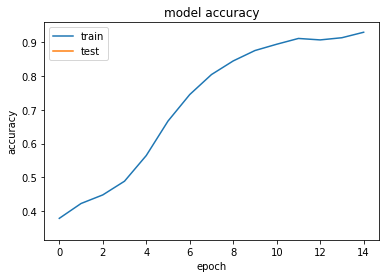

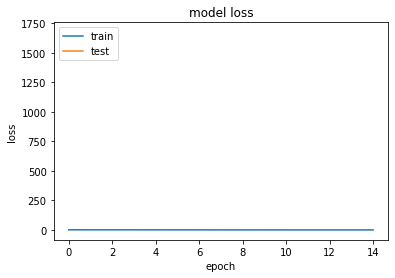

In [26]:
import matplotlib.pyplot as plt

# Gráfico de treino - acurácia
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Gráfico de treino - perda
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
# métricas de perda e acurácia
score = model.evaluate_generator(validation_generator, 2400)

print ("%s: %.2f%%" % (model.metrics_names[0], score[0]*100))
print ("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

C:\Users\rbsa2\AppData\Local\Temp/ipykernel_25220/3592405202.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(validation_generator, 2400)


loss: 329.14%
acc: 37.80%


In [29]:

model.save("model_inceptionresnetv2.h5")

In [ ]:
# Testando o modelo
from keras.preprocessing import image

test_image = image.load_img('D:/SiDi/Project/Modulo II/dataset/512/768106863531429889-1.jpg', target_size = (299, 299))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)

if result[0][0] == 0:
    diagnostico = 'Negativo'
elif result[0][0] == 1:
    diagnostico = 'Neutro'
elif result[0][0] == 2:
    diagnostico = 'Positivo'
else:
    diagnostico = 'Outros problemas'
    
print ('Classificação:', diagnostico)